# Evidencia Integradora 1 Modelo Presa-Depredador

## Armando Gutiérrez Rojo A01702748

En esta simulación se crea un Planeta en el que viven dos especies: Deddian y Nonine. Estas especies se reproducen y se alimentan de la comida que hay en el planeta. El objetivo de esta simulación es que las especies se reproduzcan y se alimenten de la comida que les corresponde (los Nonine pasto y los Deddian Nonines). Los cuadros azules representan a los Deddian y los cuadros verdes a los Nonine.

In [208]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'' se asegura que los agentes se activen en un orden aleatorio dependiendo de su tipo
from mesa.time import RandomActivationByType

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [209]:
"""
Agente Nonine
@method __init__ : Inicializa el agente con un tipo, una cantidad de comida, un
                    metabolismo, una edad y un estado de vida.
@method step : Define el comportamiento del agente en cada paso de la simulación.
@method checkIfDeddianAround : Verifica si hay un agente de tipo Deddian alrededor.
@method getCellsToReproduce : Obtiene las celdas vacías adyacentes (incluye diagonales) a la del agente.
@method getEmptyCells : Obtiene las celdas vacías adyacentes (no incluye diagonales) a la del agente.
@method reproduce : Crea un nuevo agente de tipo Nonine en una celda vacía adyacente.
@method randomMove : Mueve al agente aleatoriamente a la izquierda, derecha, arriba o abajo.
@method eat : El agente come una cantidad de comida de la celda en la que se encuentra.
"""
class NonineAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.food = 10
        self.metabolism = 3
        self.age = 0
        self.type = "Nonine"
        self.isAlive = True

    def checkIfDeddianAround (self):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        for cell in neighbors:
            if self.model.grid.is_cell_empty(cell) == False:
                for agent in self.model.grid.get_cell_list_contents(cell):
                    if agent.type == "Deddian":
                        return True
        return False
    

    def getCellsToReproduce(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        emptyCells = []
        for cell in neighbors:
            if self.model.grid.is_cell_empty(cell):
                emptyCells.append(cell)
        return emptyCells

    def getEmptyCells(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        emptyCells = []
        for cell in neighbors:
            if self.model.grid.is_cell_empty(cell):
                emptyCells.append(cell)
        return emptyCells

    def reproduce(self, cellsToReproduce):
        self.model.nonines += 1
        randIndex = np.random.randint(0, len(cellsToReproduce))
        cell = cellsToReproduce[randIndex]
        newAgent = NonineAgent(self.model.newId(), self.model)
        # self.food = self.food / 2
        # newAgent.food = self.food / 2
        self.model.grid.place_agent(newAgent, cell)
        self.model.schedule.add(newAgent)
        
    
    def randomMove(self, cellsToMove):
        randIndex = np.random.randint(0, len(cellsToMove))
        cell = cellsToMove[randIndex]
        self.model.grid.move_agent(self, cell)
    
    def eat(self):
        foodToEat = 45 - self.food
        if foodToEat > self.model.grass[self.pos[0], self.pos[1]]:
            self.food += self.model.grass[self.pos[0], self.pos[1]]
            self.model.grass[self.pos[0], self.pos[1]] = 0
        else:
            self.food += foodToEat
            self.model.grass[self.pos[0], self.pos[1]] -= foodToEat

    def step(self):
        if self.age > 25 or self.food <= 0:
            self.model.nonines -= 1
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            return
        
        if self.isAlive == False:
            self.model.nonines -= 1
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            return
        
        self.age += 1
        self.food -= self.metabolism
    
        cellsToReproduce = self.getCellsToReproduce()
        if self.age >= 10 and self.food >= 40 and cellsToReproduce and not self.checkIfDeddianAround():
            flag = np.random.choice([0, 1])
            if flag == 1:
                self.reproduce(cellsToReproduce)
        cellsToMove = self.getEmptyCells()
        if cellsToMove:
            self.randomMove(cellsToMove)
        if self.food < 45:
            self.eat()


In [210]:
"""Agente Deddian
@method __init__ : Inicializa el agente con un tipo, una cantidad de comida, un
                    metabolismo, una edad y un estado de vida.
@method step : Define el comportamiento del agente en cada paso de la simulación.
@method getCellsToReproduce : Obtiene las celdas vacías adyacentes (incluye diagonales) a la del agente.
@method getEmptyCells : Obtiene las celdas vacías adyacentes (no incluye diagonales) a la del agente.
@method getCellsWithNonines : Obtiene las celdas con agentes de tipo Nonine adyacentes (no incluye diagonales) a la del agente.
@method reproduce : Crea un nuevo agente de tipo Deddian en una celda vacía adyacente (incluye diagonales).
@method randomMove : Mueve al agente aleatoriamente a la izquierda, derecha, arriba o abajo.
@method eat : El agente se mueve a una celda con un agente de tipo Nonine y lo come.

"""
class DeddianAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.food = 150
        self.metabolism = 2
        self.age = 0
        self.type = "Deddian"
        self.isAlive = True
    
    def getCellsToReproduce(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        emptyCells = []
        for cell in neighbors:
            if self.model.grid.is_cell_empty(cell):
                emptyCells.append(cell)
        return emptyCells
        
    def getEmptyCells(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        emptyCells = []
        for cell in neighbors:
            if self.model.grid.is_cell_empty(cell):
                emptyCells.append(cell)
        return emptyCells
    
    def getCellsWithNonines(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=False, include_center=False)
        cellsWithNonine = []
        for cell in neighbors:
            if cell.type == "Nonine":
                cellsWithNonine.append(cell.pos)
        return cellsWithNonine
        
    def reproduce(self, cellsToReproduce):
        self.model.deddians += 1
        randIndex = np.random.randint(0, len(cellsToReproduce))
        cell = cellsToReproduce[randIndex]
        newAgent = DeddianAgent(self.model.newId(), self.model)
        self.food = self.food / 2
        newAgent.food = self.food / 2
        self.model.grid.place_agent(newAgent, cell)
        self.model.schedule.add(newAgent)
    
    def eat(self, cellsWithNonine):
        randIndex = np.random.randint(0, len(cellsWithNonine))
        cell = cellsWithNonine[randIndex]
        nonine = self.model.grid.get_cell_list_contents(cell)[0]
        nonine.isAlive= False
        self.food += 10
    
    def randomMove(self, cellsToMove):
        randIndex = np.random.randint(0, len(cellsToMove))
        cell = cellsToMove[randIndex]
        self.model.grid.move_agent(self, cell)
        
    def step(self):
        if self.age > 50 or self.food <= 0:
            self.model.deddians -= 1
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            return
        
        if self.isAlive== False:
            self.model.deddians -= 1
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            return
        self.age += 1
        self.food -= self.metabolism
        cellsToReproduce = self.getCellsToReproduce()
        if self.age >= 10 and self.food >= 120 and cellsToReproduce:
            flag = np.random.choice([0, 1])
            if flag == 1:
                self.reproduce(cellsToReproduce)
        
        cellsWithNonine = self.getCellsWithNonines()
        emptyCells = self.getEmptyCells()

        if self.food < 200 and cellsWithNonine:
            self.eat(cellsWithNonine)
        elif emptyCells:
            self.randomMove(emptyCells)

                
         

In [211]:
"""
Funcion para crear grid
"""
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, x, y) in model.grid.coord_iter():
       if content == None:
           grid[x][y] = 0
       elif content.type == "Nonine":
            grid[x][y] = 1
       elif content.type == "Deddian":
            grid[x][y] = 2
        
        



    return grid

In [212]:
"""
    Modelo del planeta
    @method __init__ : Inicializa el modelo con un grid, un schedule, contador de nonines y deddians,
                        un datacollector, pasto y un id inicial.
    @method newId : Retorna un nuevo id para un agente.
    @method step : Define el comportamiento del modelo en cada paso de la simulación.
"""
class PlanetModel(Model):
    def __init__(self, width= 35, height=35, nonines = 47, deddians = 15):
        self.grid = SingleGrid(width, height,True)
        self.nonines = nonines
        self.deddians = deddians
        self.schedule = RandomActivationByType(self)
        self.deddians = deddians
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        self.grass = np.zeros((width, height))
        self.grass += 20
        self.lastid = 0
        

        for i in range(self.deddians):
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)
            while self.grid[x, y] != None:
                x = np.random.randint(0, width)
                y = np.random.randint(0, height)
            agent = DeddianAgent( self.newId(), self)
            self.grid.place_agent(agent, (x,y))
            self.schedule.add(agent)

            
        for i in range(self.nonines):
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)
            while self.grid[x, y] != None:
                x = np.random.randint(0, width)
                y = np.random.randint(0, height)
            agent = NonineAgent(self.newId(), self)
            self.grid.place_agent(agent, (x,y))
            self.schedule.add(agent)
        
    
        
    def newId(self):
        newid = self.lastid + 1
        self.lastid  = newid
        return newid

    def step(self):
        self.datacollector.collect(self)
        self.grass += 1
        self.schedule.step()
        

        
        



In [215]:
GRID_SIZE = 35
NONINES = 47
DEDIANS = 15
ITERATIONS = 200

model = PlanetModel(GRID_SIZE, GRID_SIZE, NONINES, DEDIANS)
start_time = time.time()
for i in range(ITERATIONS):
    model.step()
print("Tiempo de ejecución: ", datetime.timedelta(seconds=time.time() - start_time))

Tiempo de ejecución:  0:00:01.151295


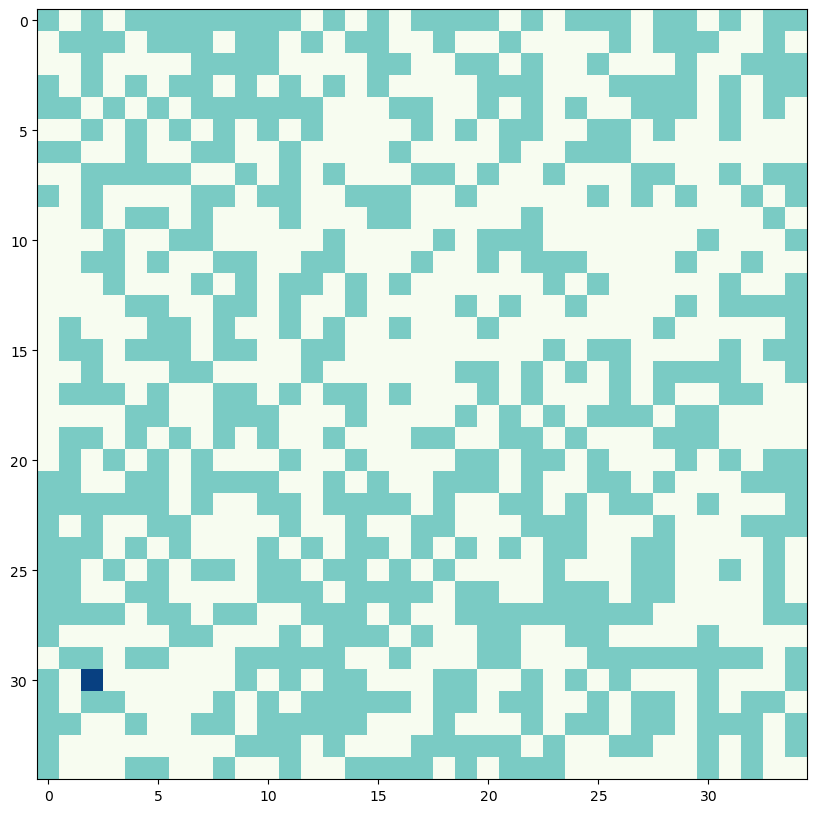

In [216]:
all_grid = model.datacollector.get_model_vars_dataframe()

fig, axs = plt.subplots(figsize=(10,10))
axs.set_xticks = ([])
axs.set_yticks = ([])
patch = plt.imshow(all_grid.iloc[0][0], cmap='GnBu', interpolation='nearest')

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig,animate,frames=ITERATIONS)
anim